In [1]:
import numpy as np
import pandas as pd
from test_estimate_distance_matrix import evaluate
from estimate_distance_matrix import distance_matrix_from_locs, estimate_distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.special import ndtr
import json
from simulate_rss_matrix import simulate_rss_matrix

In [3]:
n = 11
# fitted from dataset
params = (1.0, -46.123430636476016, 2.902844191159571, 3.9405315173088855, -100)
spring_params = (100, 0.2, 0.1, False, 3)

true_locs = np.array([[1.0,7.0],[14.0,3.0],[3.0,19.0],[21.0,18.0],[9.0,33.0],[22.0,3.0],[10.0,11.0],[3.0,32.0],[27.0,27.0],[20.0,12.0],[18.0,34.0]])
true_locs = 0.3048*true_locs # convert to meters
true_dist_matrix = distance_matrix_from_locs(true_locs)

# This data comes from: http://anrg.usc.edu/www/download_files/RSSLocalizationDataSet_11nodes.txt
rss_matrix = np.array([[-100, -68.308, -62.299, -67.051, -68.141, -66.400, -60.864, -77.891, -68.217, -69.553, -68.678],
                [-67.414, -100, -68.205, -65.299, -69.623, -55.270, -59.656, -71.891, -69.178, -65.439, -74.507],
                [-60.025, -67.713, -100, -65.146, -64.812, -67.982, -58.420, -62.949, -70.291, -68.334, -69.354],
                [-68.820, -67.432, -67.988, -100, -68.111, -64.830, -65.680, -70.307, -56.207, -53.938, -67.278],
                [-66.090, -68.082, -64.801, -64.279, -100, -73.314, -63.975, -49.990, -62.357, -71.328, -54.147],
                [-67.572, -55.854, -70.355, -64.174, -77.715, -100, -77.591, -88.658, -68.432, -57.822, -73.303],
                [-62.527, -62.622, -62.680, -65.855, -68.123, -70.461, -100, -70.402, -73.127, -65.211, -79.361],
                [-77.521, -74.398, -65.662, -70.068, -50.838, -86.564, -70.062, -100, -70.560, -81.057, -67.722],
                [-68.896, -70.385, -72.194, -54.641, -63.342, -67.637, -70.941, -69.543, -100, -65.686, -63.720],
                [-66.488, -63.775, -66.978, -51.330, -69.295, -56.240, -63.301, -78.221, -65.041, -100, -70.042],
                [-72.078, -80.838, -73.341, -68.369, -57.963, -76.385, -79.549, -68.691, -66.980, -73.718, -100]])

print(true_dist_matrix)

[[ 0.    4.15  3.71  6.96  8.29  6.52  3.    7.64 10.    5.99  9.72]
 [ 4.15  0.    5.92  5.05  9.27  2.44  2.73  9.45  8.32  3.3   9.53]
 [ 3.71  5.92  0.    5.49  4.64  7.57  3.24  3.96  7.71  5.6   6.47]
 [ 6.96  5.05  5.49  0.    5.86  4.58  3.97  6.95  3.3   1.85  4.96]
 [ 8.29  9.27  4.64  5.86  0.    9.97  6.71  1.85  5.78  7.23  2.76]
 [ 6.52  2.44  7.57  4.58  9.97  0.    4.4  10.57  7.47  2.81  9.53]
 [ 3.    2.73  3.24  3.97  6.71  4.4   0.    6.75  7.12  3.06  7.42]
 [ 7.64  9.45  3.96  6.95  1.85 10.57  6.75  0.    7.47  8.    4.61]
 [10.    8.32  7.71  3.3   5.78  7.47  7.12  7.47  0.    5.05  3.48]
 [ 5.99  3.3   5.6   1.85  7.23  2.81  3.06  8.    5.05  0.    6.73]
 [ 9.72  9.53  6.47  4.96  2.76  9.53  7.42  4.61  3.48  6.73  0.  ]]


In [7]:
# with open("scenario_data.json") as f:
#     scenarios = json.load(f)

mds: 0.8479111111111112
spring: 0.7888
mds: 0.46635695063533406
spring: 0.3498043090512037


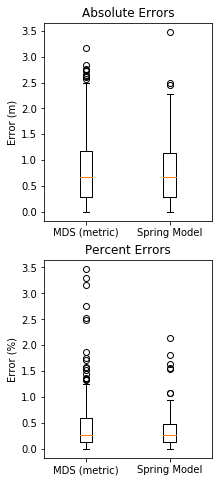

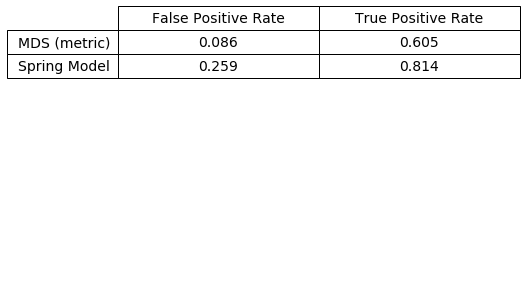

In [35]:
# for scenario in ["phone_table","phone_pocket","train","simple_grocery"]:
#     scen = scenarios[scenario]

#     n = len(scen["locs"])
#     n = len(rss_matrix)
#     params = scen["params"]
#     print(params)
#     spring_params = (100, 0.2, 0.1, False, 10)
#     true_locs = np.array(scen["locs"])
#     true_dist_matrix = distance_matrix_from_locs(true_locs)
#     rss_matrix = np.array(scen["rss"])
#     print(true_dist_matrix)
#     print(rss_matrix)

pe_mds = []
pe_spring_model = []
ae_mds = []
ae_spring_model = []

# fig0, (ax_a, ax_b) = plt.subplots(2,1,figsize=(19,10))
fig0, (ax_a, ax_b) = plt.subplots(2,1,figsize=(3,8))
ax_a_values_mds = []
ax_b_values_mds = []
ax_a_values_spring = []
ax_b_values_spring = []

##### ERROR PLOTS ###########
# fig1, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))
metrics1 = ["MAE", "STDAE", "maxAE"]
metrics2 = ["MPE", "STDPE", "maxPE"]
x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars
# models = ["rss_only","rss_pre_averaged","rss_post_averaged","mds_metric","mds_non_metric","sdp",
#           "spring_model","sdp_init_spring","isomap","lle"]
models = ["mds_metric","spring_model"]
model_names = {"mds_metric":"MDS (metric)","spring_model":"Spring Model"}
# model_names = {"rss_only":"RSS",
#                "rss_pre_averaged":"RSS (pre-averaged)",
#                "rss_post_averaged":"RSS (post-averaged)",
#                "mds_metric":"MDS (metric)", 
#                "mds_non_metric":"MDS (non-metric)", "sdp":"SDP", 
#                "spring_model":"Spring Model",
#                "sdp_init_spring":"Spring Model (from SDP)",
#                "isomap":"Isomap",
#                "lle":"Local Linear Embedding"}
# models = ["rss_only","rss_pre_averaged","rss_post_averaged"]
x = x*(len(models)+1)

####### CLASSIFICATION #########
# fig2, ax3 = plt.subplots()
fig3, ax4 = plt.subplots()
fig3.patch.set_visible(False)
ax4.axis('off')
ax4.axis('tight')
classification = []
TP_mds = 0
FP_mds = 0
TN_mds = 0
FN_mds = 0
TP_spring = 0
FP_spring = 0
TN_spring = 0
FN_spring = 0

####### PROB DENSITIES ##########
# fig4, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2,2,figsize = (15,10))

##### RUNTIME #####
# fig5, ax9 = plt.subplots(figsize=(19,4))

for iteration in range(50):
    params = (1, -75.014, 1.7919, 6.4484, -100)
    spring_params = (100, 0.2, 0.1, False, 5)
    true_locs, rss_matrix = simulate_rss_matrix(num_nodes=10, area_side=5, params=params, threshold=-95)
    true_dist_matrix = distance_matrix_from_locs(true_locs)
#     print(true_locs, rss_matrix, true_dist_matrix)

    for i, model in enumerate(models):
        dist_matrix, est_locs, time_elapsed = estimate_distance_matrix(rss_matrix,use_model=model,estimate_distance_params=params,spring_model_params=spring_params)
        MAE, STDAE, maxAE, MPE, STDPE, maxPE, TP, FP, TN, FN, absolute_errors, percent_errors = evaluate(true_dist_matrix,dist_matrix)
    #     print(scenario)
    #     print(model)
    #     print(percent_errors)
        if False:
            print("Mean absolute error:",MAE)
            print("Std Dev absolute error:",STDAE)
            print("Max absolute error:",maxAE)
            print("Mean percent error:",MPE)
            print("Std Dev percent error:",STDPE)
            print("Max percent error:",maxPE)
            print("True positive:",TP)
            print("False positive:",FP)
            print("True negative:",TN)
            print("False negative:",FN)
            print("Time elapsed:",time_elapsed)
            print("Estimated distance matrix",model)
            print(dist_matrix)

    #     ax1.bar(x+i, [MAE, STDAE, maxAE], label=model_names[model])
    #     ax2.bar(x+i, [MPE, STDPE, maxPE], label=model_names[model])

        if model == "spring_model":
            ax_a_values_spring.extend(absolute_errors)
            ax_b_values_spring.extend(percent_errors)
            TP_spring += TP
            FP_spring += FP
            TN_spring += TN
            FN_spring += FN
            
        if model == "mds_metric":
            ax_a_values_mds.extend(absolute_errors)
            ax_b_values_mds.extend(percent_errors)            
            TP_mds += TP
            FP_mds += FP
            TN_mds += TN
            FN_mds += FN
            
try:
    FPR_spring = FP_spring/(FP_spring+TN_spring)
except ZeroDivisionError:
    FPR_spring = 0
try:
    FPR_mds = FP_mds/(FP_mds+TN_mds)
except ZeroDivisionError:
    FPR_mds = 0
try:
    TPR_spring = TP_spring/(TP_spring+FN_spring)
except ZeroDivisionError:
    TRP_spring = 0
try:
    TPR_mds = TP_mds/(TP_mds+FN_mds)
except ZeroDivisionError:
    TRP_mds = 0
    
classification = [[FPR_mds,TPR_mds],[FPR_spring,TPR_spring]]
#     ax3.scatter(FPR,TPR,label=model_names[model])
# classification.append([FPR,TPR])

    #     kdeAE = gaussian_kde(absolute_errors)
    #     xAE = np.linspace(-2.5, 10, 100)
    #     kdeAE_pdf = kdeAE.evaluate(xAE)
    #     ax5.plot(xAE,kdeAE_pdf,label=model_names[model])

    #     kdePE = gaussian_kde(percent_errors)
    #     xPE = np.linspace(-1, 2.5, 100)
    #     kdePE_pdf = kdePE.evaluate(xPE)
    #     ax6.plot(xPE,kdePE_pdf,label=model_names[model])

    #     stdevAE = np.sqrt(kdeAE.covariance)[0, 0]
    #     pdeAE_cdf = ndtr(np.subtract.outer(xAE, absolute_errors)).mean(axis=1)
    #     ax7.plot(xAE, pdeAE_cdf,label=model_names[model])

    #     stdevPE = np.sqrt(kdePE.covariance)[0, 0]
    #     pdePE_cdf = ndtr(np.subtract.outer(xPE, percent_errors)).mean(axis=1)
    #     ax8.plot(xPE, pdePE_cdf,label=model_names[model])

    #     rect = ax9.bar(x[0]+i, [time_elapsed], label=model_names[model])
    #     ax9.annotate('{}'.format(round(time_elapsed,3)),
    #                 xy=(x[0]+i, time_elapsed),
    #                 xytext=(0, 1),  # 3 points vertical offset
    #                 textcoords="offset points",
    #                 ha='center', va='bottom')

ax_a.boxplot([ax_a_values_mds,ax_a_values_spring])
print("mds:",np.mean(ax_a_values_mds))
print("spring:",np.mean(ax_a_values_spring))
ax_a.set_xticklabels(list(model_names.values()))
ax_a.set_ylabel('Error (m)')
# ax_a.set_title('Absolute Errors: '+scenario)
ax_a.set_title('Absolute Errors')

ax_b.boxplot([ax_b_values_mds,ax_b_values_spring])
print("mds:",np.mean(ax_b_values_mds))
print("spring:",np.mean(ax_b_values_spring))
ax_b.set_xticklabels(list(model_names.values()))
ax_b.set_ylabel('Error (%)')
# ax_b.set_title('Percent Errors: '+scenario)
ax_b.set_title('Percent Errors')

# ##### ERROR PLOTS ###########
# ax1.set_ylabel('Error (m)')
# ax1.set_title('Absolute Errors')
# ax1.set_xticks(x+np.floor(len(models)/2))
# ax1.set_xticklabels(["Mean Absolute Error","Std Dev Absolute Error","Max Absolute Error"])
# ax1.legend()
# # ax2.yaxis.set_label_position("right")
# # ax2.yaxis.tick_right()
# ax2.set_ylabel('Error (%)')
# ax2.set_title('Percent Errors')
# ax2.set_xticks(x+np.floor(len(models)/2))
# ax2.set_xticklabels(["Mean Percent Error","Std Dev Percent Error","Max Percent Error"])
# ax2.legend()

####### CLASSIFICATION #########
# ax3.scatter(0,1)
# ax3.text(0+0.015,1,"IDEAL")
# ax3.set_xlim([0,1])
# ax3.set_ylim([0,1.1])
# ax3.set_xlabel("False Positive Rate")
# ax3.set_ylabel("True Positive Rate")
# ax3.set_title("Proximity Detection ROC")
# ax3.legend()

classification = np.round(classification,3)
df = pd.DataFrame(np.array(classification),columns=["False Positive Rate","True Positive Rate"])
the_table = ax4.table(cellText=df.values,colLabels=df.columns,loc='top',cellLoc='center',
                      rowLabels=list(model_names.values()),colWidths=[0.3 for x in df.columns],)
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(2, 2)

# ########### PROB DENSITIES ############
# ax5.set_title("Absolute Error PDF")
# ax5.set_xlabel("Error (m)")
# ax5.set_ylabel("Probability")
# ax5.legend()
# ax6.set_title("Percent Error PDF")
# ax6.set_xlabel("Error (%)")
# ax6.set_ylabel("Probability")
# ax6.legend()
# ax7.set_title("Absolute Error CDF")
# ax7.set_xlabel("Error (m)")
# ax7.set_ylabel("Cumulative Probability")
# ax7.legend()
# ax8.set_title("Percent Error CDF")
# ax8.set_xlabel("Error (%)")
# ax8.set_ylabel("Cumulative Probability")
# ax8.legend()

# ### RUNTIME ####
# # ax9.legend()
# ax9.set_ylabel('Time (s)')
# ax9.set_title('Runtime')
# ax9.set_xticks([0,1,2,3,4,5,6,7,8,9])
# ax9.set_xticklabels(list(model_names.values()))

plt.show()